In [ ]:
import json
import pandas as pd
from tqdm.notebook import tqdm
import re
import py_vncorenlp
import matplotlib.pyplot as plt


from pathlib import Path
from vncorenlp import VnCoreNLP

# A - Load datasets & Combine files

In [3]:
def load_json_by_folder(folder_path):
    folder = Path(folder_path)
    organized = {}
    
    for file in folder.rglob('*.json'):
        relative = file.relative_to(file)
        subfolder = file.parent.name
        filename = file.stem
        
        if subfolder not in organized:
            organized[subfolder] = {}
        
        with open(file, 'r', encoding='utf-8') as f:
            organized[subfolder][filename] = json.load(f)
            
    return organized

def add_fields_by_id(target_data, source_data, fields):
    if isinstance(fields, str):
        fields = [fields]
    
    # Create id-to-fields mapping
    id_to_fields = {}
    for item in source_data:
        item_id = item['id']
        id_to_fields[item_id] = {field: item.get(field) for field in fields}
    
    # Add field to target 
    for item in target_data:
        item_id = item['id']
        if item_id in id_to_fields:
            for field, value in id_to_fields[item_id].items():
                item[field] = value 
        else:
            for field in fields:
                item[field] = 'None'


In [4]:
data = load_json_by_folder(r'D:\Toxic-Language-Detection-in-Vietnamese-Social-Media\data')

splits = ['train', 'dev', 'test']

for split in splits:
    target_data = data['toxic_nontoxic'][split]
    source_data = ['hate_offensive', 'expression_type']
    for item in source_data:
        source_data = data[item][split]
        if item == 'hate_offensive':
            add_fields_by_id(target_data, source_data, 'toxic_type')
        else:
            add_fields_by_id(target_data, source_data, 'expression_type')

In [5]:
train = data['toxic_nontoxic']['train']
test = data['toxic_nontoxic']['test']
dev = data['toxic_nontoxic']['dev']

In [6]:
print('Train Length =', len(train))
print('Test Length =', len(test))
print('Dev Length =', len(dev))

Train Length = 27934
Test Length = 3449
Dev Length = 3104


In [60]:
def analyze_dataset(train, dev, test):
    def get_stats(dataset):
        texts = [item['text'] for item in dataset]

        # Vocab
        all_words = ' '.join(texts).split()
        vocab = {w for w in all_words if any(c.isalpha() for c in w)}
                
        # Average length
        avg_len = sum(len(text) for text in texts) / len(texts)
        
        return {
            'Num. comments': len(dataset),
            'Vocab. size': len(vocab),
            'Avg. length': round(avg_len, 2)
        }
    
    stats = pd.DataFrame({
        'train': get_stats(train),
        'dev': get_stats(dev),
        'test': get_stats(test)
    })
    
    return stats

In [61]:
stats_table = analyze_dataset(toxic_nontoxic_train, toxic_nontoxic_dev, toxic_nontoxic_test)
print(stats_table)

                  train      dev     test
Num. comments  27934.00  3104.00  3449.00
Vocab. size    23961.00  6045.00  6710.00
Avg. length       69.03    64.07    67.91


# B - Tokenize

In [2]:
py_vncorenlp.download_model(save_dir='D:\Toxic-Language-Detection-in-Vietnamese-Social-Media\VnCoreNLP-master\VnCoreNLP-master')

model = py_vncorenlp.VnCoreNLP(annotators=["wseg"], save_dir='D:\Toxic-Language-Detection-in-Vietnamese-Social-Media\VnCoreNLP-master\VnCoreNLP-master')

VnCoreNLP model folder D:\Toxic-Language-Detection-in-Vietnamese-Social-Media\VnCoreNLP-master\VnCoreNLP-master already exists! Please load VnCoreNLP from this folder!


In [7]:
def remove_emoji(text):
    emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F" 
        u"\U0001F300-\U0001F5FF" 
        u"\U0001F680-\U0001F6FF"  
        u"\U0001F1E0-\U0001F1FF"  
        u"\U00002500-\U00002BEF"  
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U00010000-\U0010ffff"
        u"\u2640-\u2642" 
        u"\u2600-\u2B55"
        u"\u200d"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\ufe0f"  # dingbats
        u"\u3030"
        "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

def tokenize_text(text, model):
    try:
        text = remove_emoji(text)
        result = model.word_segment(text) #tokenize word 
        tokenized_text = ' '.join(result) #convert list to string
        tokenized_text = re.sub(r'\s*_\s*', '_', tokenized_text) # Remove space around _
        return tokenized_text
    except Exception as e:
        print(f"Error: {e}")
        return text

def tokenize_dataset(data_list, model):
    for item in data_list:
        item['text'] = tokenize_text(item['text'], model)
    return data_list

In [8]:
train_tokenized = tokenize_dataset(train, model)
test_tokenized = tokenize_dataset(test, model)
dev_tokenized = tokenize_dataset(dev, model)

# C - Number of comments & Vocab size & Average Length

In [10]:
def analyze_dataset_statistics(train, dev, test):
    def get_vocab(data):
        vocab = set()
        for item in data:
            tokens = item['text'].split()
            vocab.update(tokens)
        return vocab
    
    def get_avg_length(data):
        total_length = sum(len(item['text'].split()) for item in data)
        return total_length / len(data)
    
    stats = {
        'train': {
            'Num. comments': len(train),
            'Vocab. size': len(get_vocab(train)),
            'Avg. length': round(get_avg_length(train), 2)
        },
        'dev': {
            'Num. comments': len(dev),
            'Vocab. size': len(get_vocab(dev)),
            'Avg. length': round(get_avg_length(dev), 2)
        },
        'test': {
            'Num. comments': len(test),
            'Vocab. size': len(get_vocab(test)),
            'Avg. length': round(get_avg_length(test), 2)
        }
    }
    
    # Convert to DataFrame
    df = pd.DataFrame(stats)
    
    return df

# D - Length Distribution

In [17]:
def analyze_length_distribution(train, dev, test):
    def get_length(data):
        return [len(item['text'].split()) for item in data] # get length of each item in dataset
    
    train_lengths = get_length(train)
    dev_lengths = get_length(dev)
    test_lengths = get_length(test)
    
    train_stats = pd.Series(train_lengths).describe(percentiles=[0.25, 0.5, 0.75])
    dev_stats = pd.Series(dev_lengths).describe(percentiles=[0.25, 0.5, 0.75])
    test_stats = pd.Series(test_lengths).describe(percentiles=[0.25, 0.5, 0.75])
    
    stats_df = pd.DataFrame({
        'Train': [
            int(train_stats['min']),
            int(train_stats['25%']),
            int(train_stats['50%']),
            int(train_stats['75%']),
            int(train_stats['max'])
        ],
        'Dev': [
            int(dev_stats['min']),
            int(dev_stats['25%']),
            int(dev_stats['50%']),
            int(dev_stats['75%']),
            int(dev_stats['max'])
        ],
        'Test': [
            int(test_stats['min']),
            int(test_stats['25%']),
            int(test_stats['50%']),
            int(test_stats['75%']),
            int(test_stats['max'])
        ]
    }, index=['Min', '25%', 'Median', '75%', 'Max'])
    
    return stats_df, train_lengths, dev_lengths, test_lengths

In [19]:
stats_table, train_len, dev_len, test_len = analyze_length_distribution(
    train_tokenized,
    dev_tokenized,
    test_tokenized
)

print("Table 6: Statistical information about the length distribution")
print(stats_table)
print()

Table 6: Statistical information about the length distribution
        Train  Dev  Test
Min         1    1     1
25%         5    5     5
Median      9    9     9
75%        17   17    17
Max      1385  570   592



In [40]:
def plot_length_distribution(train_lengths, dev_lengths, test_lengths):
    fig, axes = plt.subplots(1, 3, figsize=(15, 6))
    
    # Training set
    axes[0].boxplot(train_lengths, patch_artist=True,
                    boxprops=dict(facecolor='lightseagreen', alpha=0.7),
                    medianprops=dict(color='black', linewidth=2))
    axes[0].set_title('TRAINING SET', fontsize=12, fontweight='bold')
    axes[0].set_ylabel('Độ dài', fontsize=11)
    axes[0].grid(axis='y', alpha=0.3)
    
    # Dev set
    axes[1].boxplot(dev_lengths, patch_artist=True,
                    boxprops=dict(facecolor='indianred', alpha=0.7),
                    medianprops=dict(color='black', linewidth=2))
    axes[1].set_title('DEV SET', fontsize=12, fontweight='bold')
    axes[1].grid(axis='y', alpha=0.3)
    
    # Test set
    axes[2].boxplot(test_lengths, patch_artist=True,
                    boxprops=dict(facecolor='lightskyblue', alpha=0.7),
                    medianprops=dict(color='black', linewidth=2))
    axes[2].set_title('TEST SET', fontsize=12, fontweight='bold')
    axes[2].grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('length_distribution.png', dpi=300, bbox_inches='tight')
    plt.show()

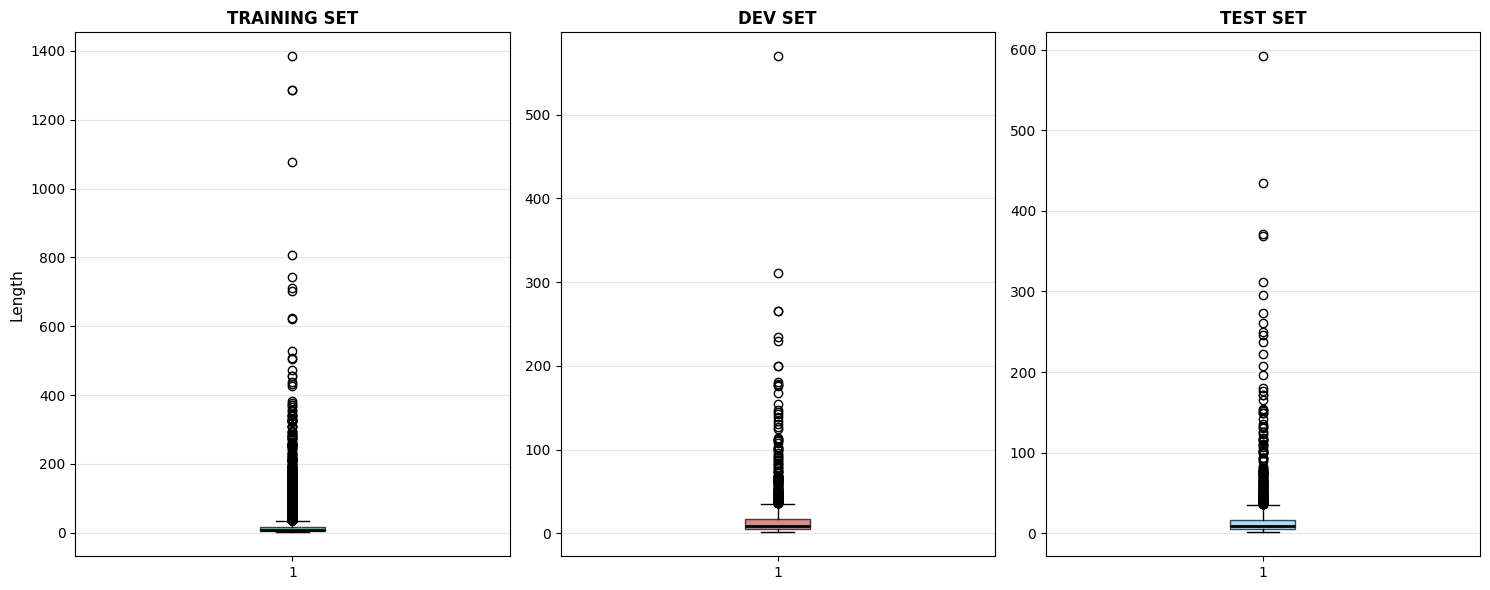

In [ ]:
plot_length_distribution(train_len, dev_len, test_len)

print max value of train

In [29]:
element = 1385
train_len.index(element)

22774

In [31]:
train_tokenized[22774]['text']

'về cúng dường ( cung_dưỡng ) : khất_thực và cúng dường đều là “ pháp gieo duyên ” về mục_đích và tính_chất thì như nhau . . đạo phật không phải chỉ tu cho mình mà “ độ hoá “ cho nhân_loại . cho_nên những bậc tu_hành thường cố_gắng hoằng_hoá đạo_pháp để giúp chúng_sinh giãi thoát . học_thuyết “ nghiệp là một trụ_cột của đạo phật . nghiệp thì có_nghiệp tốt ( phước ) và nghiệp xấu ( hoạ ) . ai tạo nghiệp tốt thì sẽ nhận được nghiệp tốt . ai tạo nghiệp xấu thì sẽ nhận được nghiệp xấu . bố_thí , cúng dường là cách tạo ra nghiệp tốt . cho_nên những vị chân_tu trên con đường hoằng_hoá đạo_pháp , cố_gắng giúp cho chúng_sinh “ tạo phước càng nhiều càng tốt ” . ai chưa có cơ_hội làm_phước thì người đi_tu tạo điều_kiện cho họ làm_phước để được hưỡng phước về sau . cho_nên cái chuyện khuyên người ta làm_phước để được hưởng phước là chuyện xưa như trái_đất . về cúng dường thì tất_cả đạo_giáo đều có cúng dường ( đóng_góp ) hết . bên công_giáo , các nhà_thờ đồ_sộ khắp_nơi , đâu phải tiền của các ông

# E - Number of comments for each category

In [33]:
def summarize_by_category(train, dev, test):
    def count_categories(data):
        category_counts = {}
        for item in data:
            category = item['category']
            category_counts[category] = category_counts.get(category, 0) + 1
        return category_counts
    
    train_counts = count_categories(train)
    dev_counts = count_categories(dev)
    test_counts = count_categories(test)
    
    all_categories = set(train_counts.keys()) | set(dev_counts.keys()) | set(test_counts.keys())
    
    summary = {}
    for category in sorted(all_categories):
        summary[category] = {
            'Train': train_counts.get(category, 0),
            'Dev': dev_counts.get(category, 0),
            'Test': test_counts.get(category, 0)
        }
    
    df = pd.DataFrame(summary).T
    df['Total'] = df.sum(axis=1)
    
    df.loc['Total'] = df.sum()
    return df
    

In [34]:
category_summary = summarize_by_category(
    train_tokenized,
    dev_tokenized,
    test_tokenized
)

print("Distribution of comments by category")
print(category_summary)

Distribution of comments by category
            Train   Dev  Test  Total
appearance   3302   382   419   4103
disease      4835   524   592   5951
lgbtq        6229   708   773   7710
region       6543   694   770   8007
religion     5924   678   752   7354
sexism       1101   118   143   1362
Total       27934  3104  3449  34487


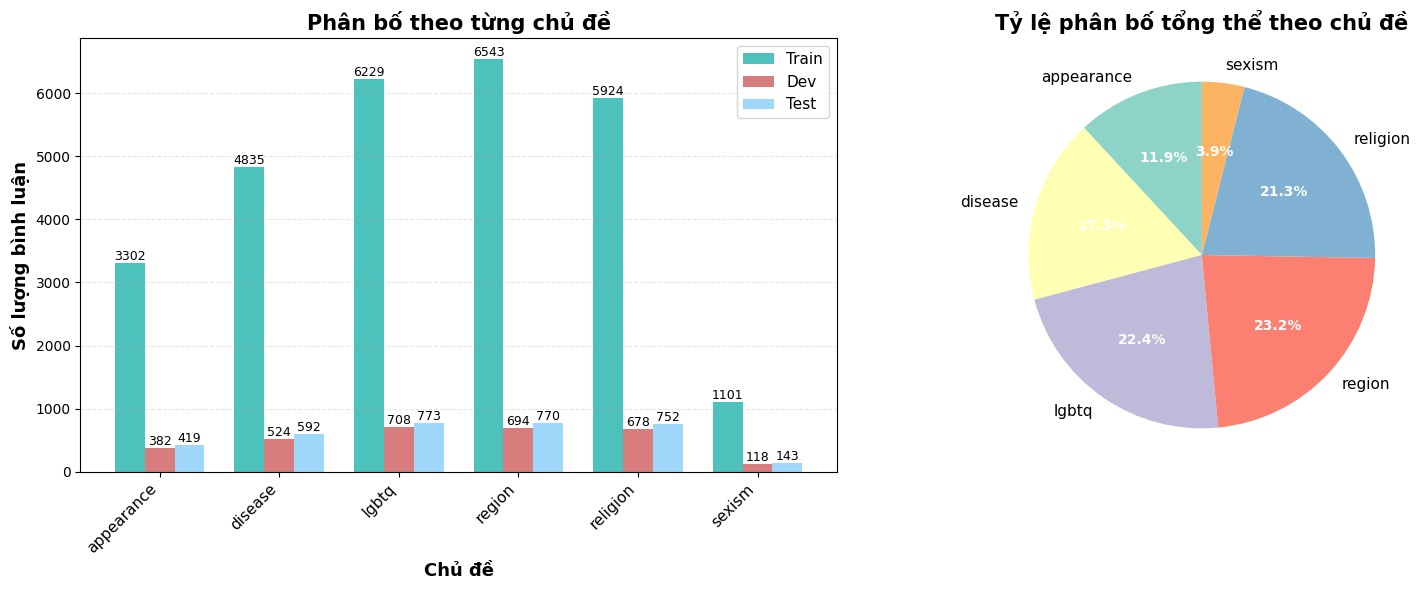

In [39]:
import matplotlib.pyplot as plt

def visualize_category_distribution(train_data, dev_data, test_data):
    """
    Visualize category distribution with pie chart and bar chart
    """
    
    def count_categories(data):
        category_counts = {}
        for item in data:
            category = item['category']
            category_counts[category] = category_counts.get(category, 0) + 1
        return category_counts
    
    # Get counts
    train_counts = count_categories(train_data)
    dev_counts = count_categories(dev_data)
    test_counts = count_categories(test_data)
    
    # Get all categories
    all_categories = sorted(set(train_counts.keys()) | set(dev_counts.keys()) | set(test_counts.keys()))
    
    # Prepare data
    train_vals = [train_counts.get(cat, 0) for cat in all_categories]
    dev_vals = [dev_counts.get(cat, 0) for cat in all_categories]
    test_vals = [test_counts.get(cat, 0) for cat in all_categories]
    total_vals = [train_vals[i] + dev_vals[i] + test_vals[i] for i in range(len(all_categories))]
    
    # Create figure with 2 subplots
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # 1. Bar Chart
    x = range(len(all_categories))
    width = 0.25
    
    axes[0].bar([i - width for i in x], train_vals, width, label='Train', color='lightseagreen', alpha=0.8)
    axes[0].bar(x, dev_vals, width, label='Dev', color='indianred', alpha=0.8)
    axes[0].bar([i + width for i in x], test_vals, width, label='Test', color='lightskyblue', alpha=0.8)
    
    axes[0].set_xlabel('Chủ đề', fontsize=13, fontweight='bold')
    axes[0].set_ylabel('Số lượng bình luận', fontsize=13, fontweight='bold')
    axes[0].set_title('Phân bố theo từng chủ đề', fontsize=15, fontweight='bold')
    axes[0].set_xticks(x)
    axes[0].set_xticklabels(all_categories, rotation=45, ha='right', fontsize=11)
    axes[0].legend(fontsize=11)
    axes[0].grid(axis='y', alpha=0.3, linestyle='--')
    
    # Add value labels on bars
    for i in x:
        if train_vals[i] > 0:
            axes[0].text(i - width, train_vals[i], str(train_vals[i]), 
                        ha='center', va='bottom', fontsize=9)
        if dev_vals[i] > 0:
            axes[0].text(i, dev_vals[i], str(dev_vals[i]), 
                        ha='center', va='bottom', fontsize=9)
        if test_vals[i] > 0:
            axes[0].text(i + width, test_vals[i], str(test_vals[i]), 
                        ha='center', va='bottom', fontsize=9)
    
    # 2. Pie Chart
    colors = plt.cm.Set3(range(len(all_categories)))
    
    wedges, texts, autotexts = axes[1].pie(total_vals, labels=all_categories, 
                                            autopct='%1.1f%%', colors=colors, 
                                            startangle=90, textprops={'fontsize': 11})
    
    # Make percentage text bold
    for autotext in autotexts:
        autotext.set_color('white')
        autotext.set_fontweight('bold')
        autotext.set_fontsize(10)
    
    axes[1].set_title('Tỷ lệ phân bố tổng thể theo chủ đề', fontsize=15, fontweight='bold')
    
    plt.tight_layout()
    plt.show()    

# Usage
visualize_category_distribution(
    train_tokenized,
    dev_tokenized,
    test_tokenized
)